## **Transfer Learning using Fine Tuning Method -- Without Data Augmentation**

Transfer learning is a machine learning ***`technique that allows a model trained on one task to be reused or adapted for a different task`***. There are two main types of transfer learning:

* ***`Feature Extraction:`*** In feature extraction, a pre-trained model is used as a fixed feature extractor. The pre-trained model is typically trained on a large dataset, such as ImageNet, and the final layer(s) that output the class predictions are removed. The remaining layers are then used as a feature extractor for a new dataset. These extracted features can be used as input to train a new model on the new dataset.

* ***`Fine-tuning:`*** In fine-tuning, a pre-trained model is used as an initialization for a new model. The pre-trained model is typically trained on a large dataset, such as ImageNet, and the final layer(s) that output the class predictions are replaced with new ones for the new task. The new model is then trained on the new dataset while keeping the weights of the pre-trained layers fixed or with a small learning rate. 




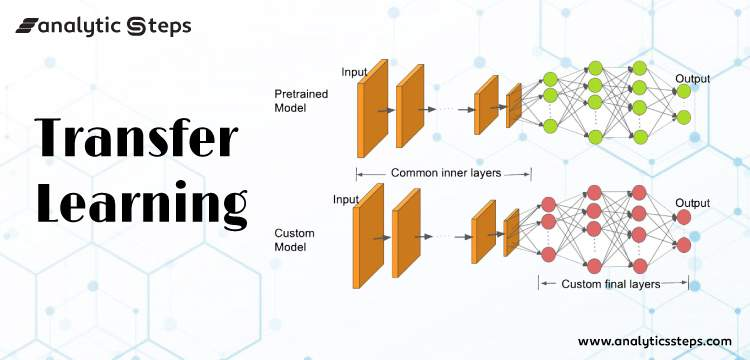

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

### ***Downloading & Loading the dataset***

In [ ]:
!kaggle datasets download -d salader/dogs-vs-cats

100% 1.06G/1.06G [00:05<00:00, 196MB/s]
100% 1.06G/1.06G [00:05<00:00, 197MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

### ***Import Necessary Libraries***

In [ ]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten
from keras.applications.vgg16 import VGG16

### ***Defining the Convolutional Base & Freezing it & discarding the top layer (Dense Layer to train again)***

In [ ]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(150,150,3)
)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


From the model.summary(), it can be easilty insighted that we're freezing the convolutional_layer upto block4 & training block5. 

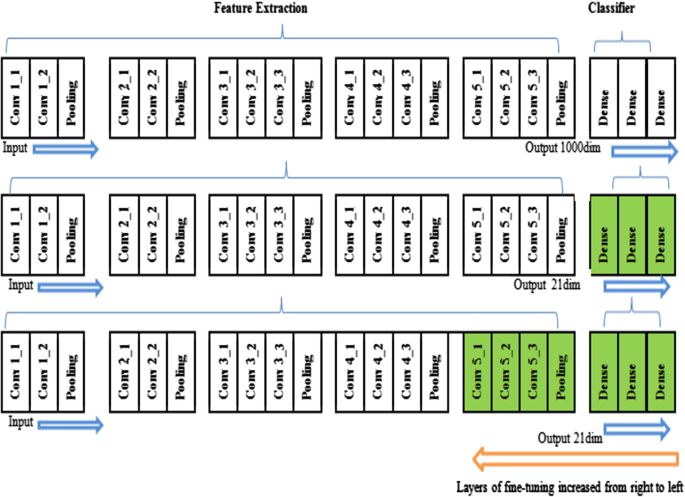

***The above image shows the actual difference between feature extraction & fine-tuning methods of Transfer Learning.***

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

Here it can be noticed that the Trainable Parameters have been reduced to **`7,079,424`** from **`14,714,688`** (Taking the conv_base 5 layer block).(After adding the **`dense layer (2,097,665) to the conv_base (14,714,688)`**).

### ***Defining the sequential model & adding the conv_base***

In [ ]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

### ***Defining Training & Validation set for model training***

In [ ]:
# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


### ***Normalizing the dataset for smooth training***

In [ ]:
# Normalize
def process(image,label):
    image = tensorflow.cast(image/255. ,tensorflow.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

### ***Model Training***

In [ ]:
model.compile(
    optimizer=keras.optimizers.RMSprop(lr=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
  )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
625/625 [==============================] - 87s 119ms/step - loss: 0.2385 - accuracy: 0.8968 - val_loss: 0.1606 - val_accuracy: 0.9352
Epoch 2/10
625/625 [==============================] - 76s 120ms/step - loss: 0.1311 - accuracy: 0.9468 - val_loss: 0.1308 - val_accuracy: 0.9470
Epoch 3/10
625/625 [==============================] - 75s 120ms/step - loss: 0.0921 - accuracy: 0.9643 - val_loss: 0.1247 - val_accuracy: 0.9488
Epoch 4/10
625/625 [==============================] - 83s 132ms/step - loss: 0.0650 - accuracy: 0.9772 - val_loss: 0.1391 - val_accuracy: 0.9452
Epoch 5/10
625/625 [==============================] - 75s 120ms/step - loss: 0.0430 - accuracy: 0.9864 - val_loss: 0.1278 - val_accuracy: 0.9512
Epoch 6/10
625/625 [==============================] - 76s 121ms/step - loss: 0.0280 - accuracy: 0.9924 - val_loss: 0.1371 - val_accuracy: 0.9528
Epoch 7/10
625/625 [==============================] - 75s 120ms/step - loss: 0.0169 - accuracy: 0.9955 - val_loss: 0.1633 - val_ac

### ***Loss curve for Accuracy***

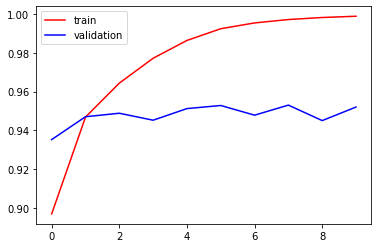

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

### ***Loss curve for training loss***

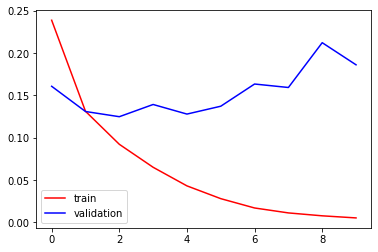

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

**Name:** Shobhandeb Paul  <br>
**Linkedin:** https://www.linkedin.com/in/shobhandeb-paul/ <br>
**Github:** https://github.com/herbert0419 